In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.optim as optim

In [12]:
#! Hyperparameters

# 1 layer of 50 neurons
# loss function: mean root square error
# optimizer: stochastic gradient descent
# epocs = 200

batch_size = 64
validation = .2
learning_rate = .01
seed = 42

In [13]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
df = pd.read_csv("Data/Processed/data.csv")
X = df.loc[:, df.columns != 'glucose_t+1']
y = df["glucose_t+1"]

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = seed)

train_data = TabularDataset(X_train, y_train)
val_data = TabularDataset(X_val, y_val)
test_data = TabularDataset(X_test, y_test)

In [16]:
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
validation_loader = DataLoader(val_data, batch_size=batch_size) 

In [17]:
# Define the Neural Network
class BaseLine(nn.Module):
    def __init__(self, input_dim):
        super(BaseLine, self).__init__()
        self.fc = nn.Linear(input_dim, 50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.output(x)

# Initialize model, optimizer
input_dim = X.shape[1]
model = BaseLine(input_dim=input_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Define MRSE Loss Function
def MRSELoss(preds, targets):
    return torch.sqrt(nn.MSELoss()(preds, targets))

# Training & Validation
num_epochs = 600
train_loss_mrse = []
val_loss_mrse = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_y = batch_y.view(-1, 1).float()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = MRSELoss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_mrse.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in validation_loader:
            val_y = val_y.view(-1, 1).float()
            preds = model(val_X)
            loss = MRSELoss(preds, val_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_loader)
    val_loss_mrse.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train MRSE: {avg_train_loss:.4f} | Val MRSE: {avg_val_loss:.4f}")


Epoch 1/600 | Train MRSE: 29.5168 | Val MRSE: 8.5422
Epoch 2/600 | Train MRSE: 7.9613 | Val MRSE: 7.5506
Epoch 3/600 | Train MRSE: 7.9862 | Val MRSE: 7.6848
Epoch 4/600 | Train MRSE: 8.0196 | Val MRSE: 7.8614
Epoch 5/600 | Train MRSE: 7.9575 | Val MRSE: 7.8345
Epoch 6/600 | Train MRSE: 7.8869 | Val MRSE: 7.7568
Epoch 7/600 | Train MRSE: 7.8755 | Val MRSE: 7.7855
Epoch 8/600 | Train MRSE: 7.8774 | Val MRSE: 7.7757
Epoch 9/600 | Train MRSE: 7.8816 | Val MRSE: 7.7905
Epoch 10/600 | Train MRSE: 7.8863 | Val MRSE: 7.7869
Epoch 11/600 | Train MRSE: 7.8917 | Val MRSE: 7.8227
Epoch 12/600 | Train MRSE: 7.8947 | Val MRSE: 7.8253
Epoch 13/600 | Train MRSE: 7.8873 | Val MRSE: 7.8076
Epoch 14/600 | Train MRSE: 7.8829 | Val MRSE: 7.7699
Epoch 15/600 | Train MRSE: 7.8855 | Val MRSE: 7.8239
Epoch 16/600 | Train MRSE: 7.8746 | Val MRSE: 7.7720
Epoch 17/600 | Train MRSE: 7.8717 | Val MRSE: 7.7773
Epoch 18/600 | Train MRSE: 7.8709 | Val MRSE: 7.7667
Epoch 19/600 | Train MRSE: 7.8691 | Val MRSE: 7.7694
E

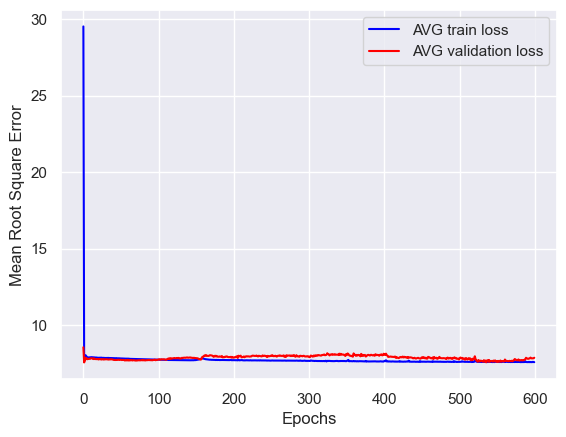

In [18]:
fig, ax = plt.subplots()
ax.plot(train_loss_mrse, color = "blue", label = "AVG train loss")
ax.plot(val_loss_mrse, color = "red", label = "AVG validation loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Root Square Error")
plt.legend()
plt.show()